In [9]:
'''Clean up trip data files into unified dataset

'''

# %% Initialize
# import glob
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

# import geocoder
# import cartopy.crs as ccrs
# from cartopy.io.img_tiles import OSM

path = 'data/'

In [58]:
# Read data
data = pd.read_pickle(f'{path}all_data_cities.pkl')

In [11]:
data['gender'].unique()

array([ 1., nan,  0.])

In [43]:
# Gender - 0=male; 1=female (changed above)
def data_gender(df):
    df.dropna(subset=['gender'], inplace=True)

    gender = df.groupby(by=[data['start_time'].dt.date]).agg({'gender': 'mean'})
    gender.index = pd.to_datetime(gender.index)
    gender_cities = data.groupby(by=[data['start_time'].dt.date, data['start_city'], data['end_city']]).agg({'gender': 'mean'}).reset_index()
    gender_cities.set_index('start_time', inplace=True)
    gender_cities.index = pd.to_datetime(gender_cities.index)

    return gender, gender_cities

# Age
def data_age(df):
    df.dropna(subset=['birth_year'], inplace=True)
    df['age'] = df['start_time'].dt.year - df['birth_year']

    df.drop(df[(df['age'] > 80) | (df['birth_year'] == 1969)].index, inplace=True)

    return df

# User type
def data_user(df):
    df.dropna(subset=['user_type'], inplace=True)

    usertype = df.groupby(by=[df['start_time'].dt.date]).agg({'user_type': 'mean'})
    usertype.index = pd.to_datetime(usertype.index)
    
    usertype_cities = df.groupby(by=[df['start_time'].dt.date, df['start_city'], data['end_city']]).agg({'user_type': 'mean'}).reset_index()
    usertype_cities.set_index('start_time', inplace=True)
    usertype_cities.index = pd.to_datetime(usertype_cities.index)

    return usertype, usertype_cities


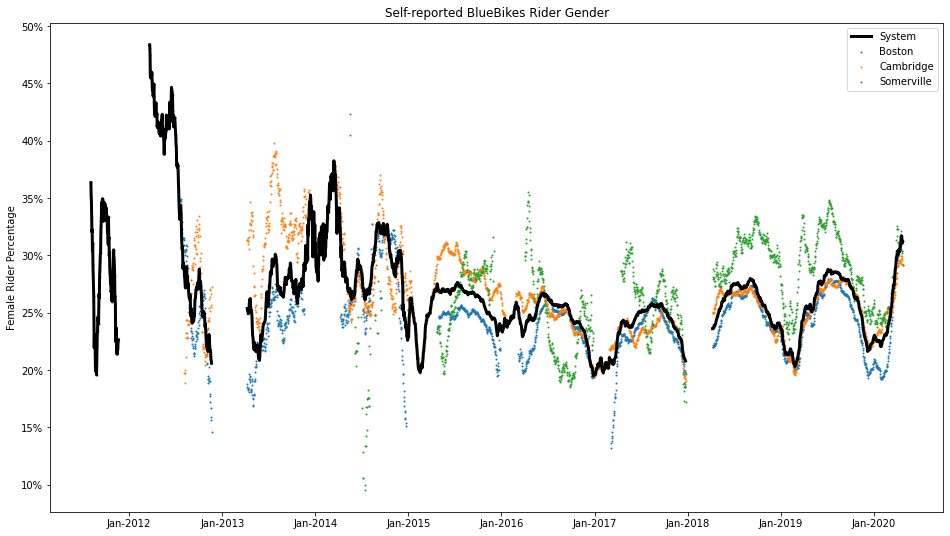

In [35]:
# Plots! - Gender
dataGender, dataGenderCities = data_gender(data)

fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

cityList = ['Boston', 'Cambridge', 'Somerville']

roll_days = 28
min_period = int(roll_days * 0.8)

gender_roll = dataGender.rolling(f'{roll_days}D', min_periods=min_period, center=True).mean()
# ax.scatter(dataGender.index, dataGender['gender'], s=3)
ax.plot(gender_roll, linewidth=3, label='System', color='black')

citiesData = []
labels = []
for city in cityList:
    cityData = dataGenderCities['gender'].loc[(dataGenderCities['start_city'] == city) & (dataGenderCities['end_city'] == city)]
    city_gender_roll = cityData.rolling(f'{roll_days}D', min_periods=min_period, center=True).mean()
    # ax.plot(city_gender_roll, linewidth=1, label=city)
    ax.scatter(city_gender_roll.index, city_gender_roll, s=1, label=city)
    # ax.scatter(cityData.index, cityData, s=1)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_ylabel('Female Rider Percentage')
ax.set_title('Self-reported BlueBikes Rider Gender')
ax.legend()
plt.show()

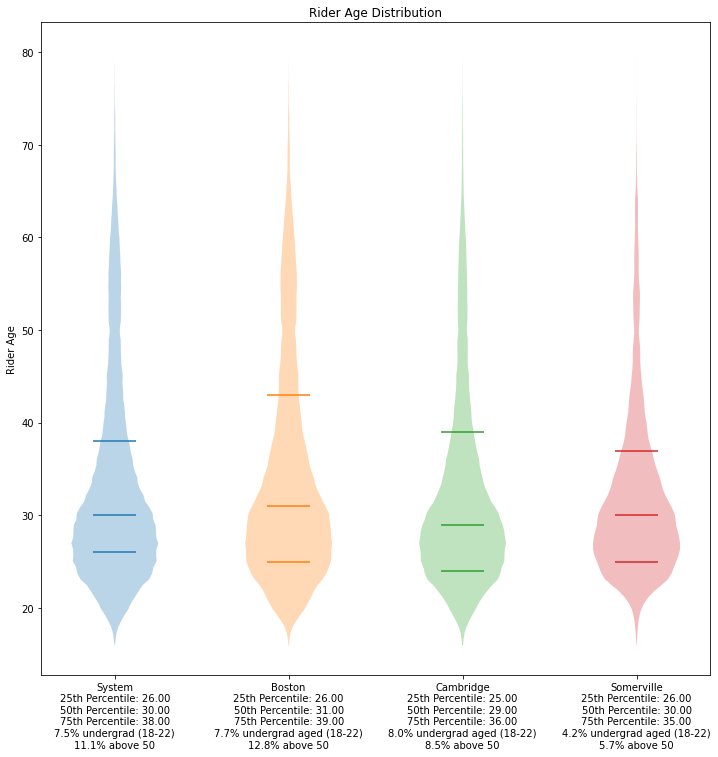

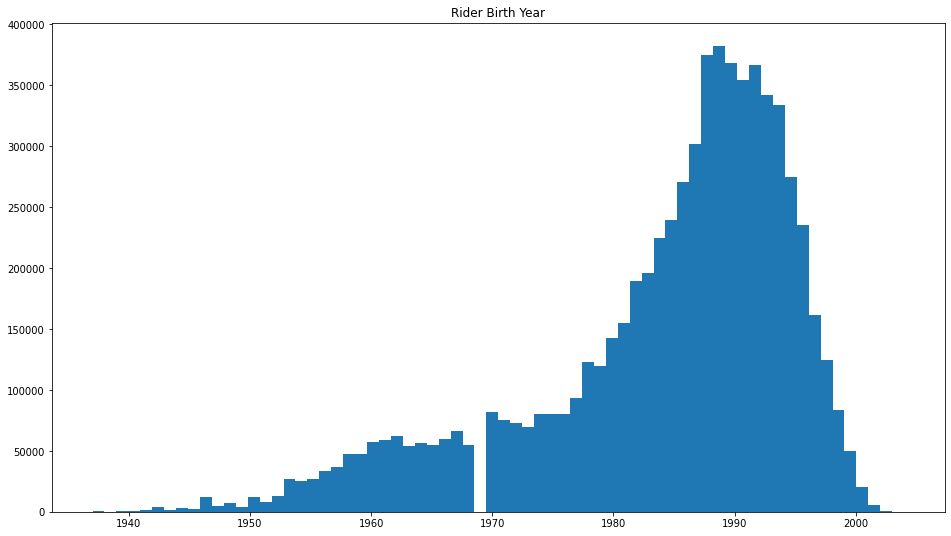

In [39]:
# Plots! - Age
dataAge = data_age(data)

# Violin plot of Rider Age
fig = plt.figure(figsize=(12,12), facecolor='white')
ax = fig.add_subplot(1,1,1)

q50 = dataAge['age'].quantile(0.5)
q75 = dataAge['age'].quantile(0.75)
q25 = dataAge['age'].quantile(0.25)
olderage = 100 - stats.percentileofscore(dataAge['age'], 50)
collegeage = stats.percentileofscore(dataAge['age'], 22) - stats.percentileofscore(dataAge['age'], 18)
label = f'System\n25th Percentile: {q25:0.2f}\n50th Percentile: {q50:0.2f}\n75th Percentile: {q75:0.2f}\n{collegeage:0.1f}% undergrad (18-22)\n{olderage:0.1f}% above 50'
ax.violinplot(dataset=dataAge['age'], positions=[1], quantiles=[.25,.5,.75], showextrema=False)

labels = [label]
cityAges = []

for i, city in enumerate(cityList):
    cityData = dataAge['age'].loc[(dataAge['start_city'] == city) | (dataAge['end_city'] == city)]
    q50 = cityData.quantile(0.5)
    q75 = cityData.quantile(0.75)
    q25 = cityData.quantile(0.25)
    olderage = 100 - stats.percentileofscore(cityData, 50)
    collegeage = stats.percentileofscore(cityData, 22) - stats.percentileofscore(cityData, 18)
    label = f'{city}\n25th Percentile: {q25:0.2f}\n50th Percentile: {q50:0.2f}\n75th Percentile: {q75:0.2f}\n{collegeage:0.1f}% undergrad aged (18-22)\n{olderage:0.1f}% above 50'
    cityAges.append([cityData])
    labels.append(label)

    ax.violinplot(dataset=cityData, positions=[i+2], quantiles=[.2,.5,.8], showextrema=False)

ax.set_xticks(list(range(1,len(cityList)+2)), labels=labels)

ax.set_ylabel('Rider Age')
ax.set_title('Rider Age Distribution')
plt.show()


# Histogram of birth years
fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

bins = int(dataAge['birth_year'].max() - dataAge['birth_year'].min() + 1)

ax.hist(dataAge['birth_year'], bins=bins)
ax.set_title('Rider Birth Year')
plt.show()

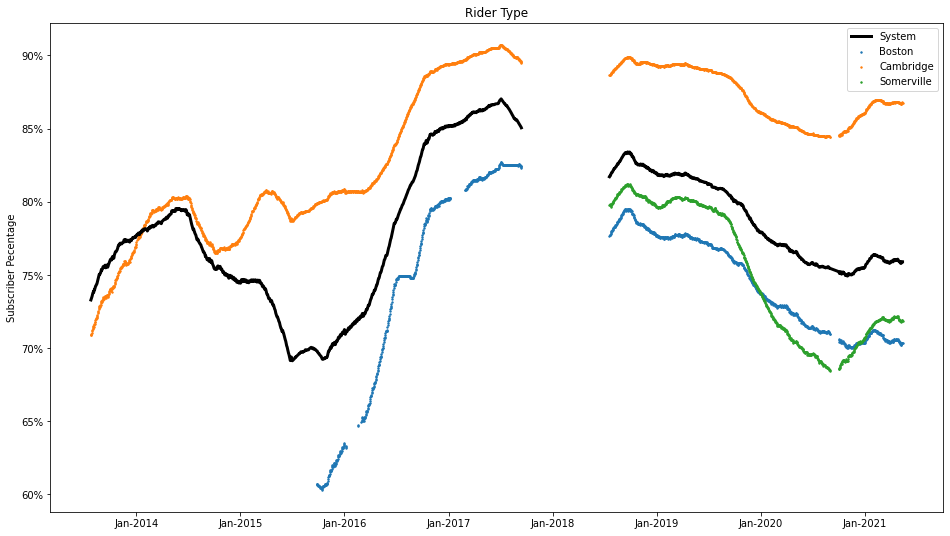

In [63]:
# Plots! - Rider Type
dataUser, dataUserCities = data_user(data)

fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

roll_days = 28
min_period = int(roll_days * 0.8)

usertype_roll = dataUser.rolling(f'{roll_days}D', min_periods=min_period, center=True).mean()
# ax.scatter(dataUser.index, dataUser['user_type'], s=3)
ax.plot(usertype_roll, linewidth=3, label='System', color='black')
# ax.scatter(usertype_roll.index, usertype_roll, s=5, label='System')

citiesData = []
labels = []
for city in cityList:
    cityData = dataUserCities['user_type'].loc[(dataUserCities['start_city'] == city) & (dataUserCities['end_city'] == city)]
    city_usertype_roll = cityData.rolling(f'{roll_days}D', min_periods=min_period, center=True).mean()
    # ax.plot(city_usertype_roll, linewidth=3, label=city)
    ax.scatter(city_usertype_roll.index, city_usertype_roll, s=2, label=city)
    # ax.scatter(cityData.index, cityData, s=1)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_ylabel('Subscriber Pecentage')
ax.set_title('Rider Type')
ax.legend()
plt.show()

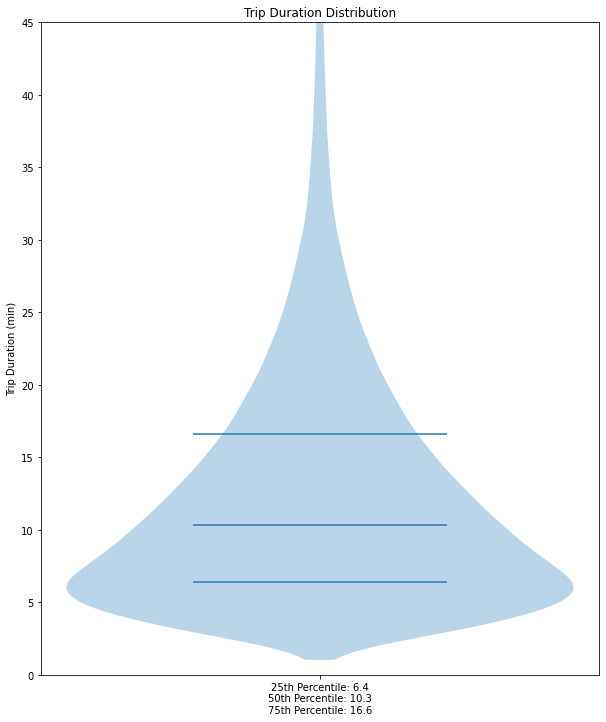

In [57]:
# Plots! - Trip Duration

df = data.drop(data[(data['duration'] > 4*60*60)].index)

q50 = df['duration'].quantile(0.5) / 60
q75 = df['duration'].quantile(0.75) / 60
q25 = df['duration'].quantile(0.25) / 60
label = [f'25th Percentile: {q25:0.1f}\n50th Percentile: {q50:0.1f}\n75th Percentile: {q75:0.1f}']

# Violin plot of Trip Duration
fig = plt.figure(figsize=(10,12), facecolor='white')
ax = fig.add_subplot(1,1,1)

ax.violinplot(dataset=df['duration']/60, quantiles=[.25,.5,.75], showextrema=False, points=1000)

ax.set_xticks([1], labels=label)
ax.set_ylim([0,45])
ax.set_ylabel('Trip Duration (min)')
ax.set_title('Trip Duration Distribution')
plt.show()


# # Histogram of trip duration
# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(1,1,1)

# # bins = df['birth year'].max() - df['birth year'].min() + 1

# ax.hist(df['tripduration'])
# # ax.hist(df['tripduration'], bins=bins)
# ax.set_title('Trip Duration')
# plt.show()